In [183]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Inplt data files are available in the "../inplt/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the inplt directory

import os
for dirname, _, filenames in os.walk('/kaggle/inplt'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as outplt.

In [184]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  # Use plt as plt (standard practice)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from tensorflow.keras.utils import to_categorical

In [229]:
df = pd.read_csv('/Users/huyguy/Documents/Documents - Huy’s MacBook Pro/UW/Clubs/Synaptech/truthinators/CNN Model/facial/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [230]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [231]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [232]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

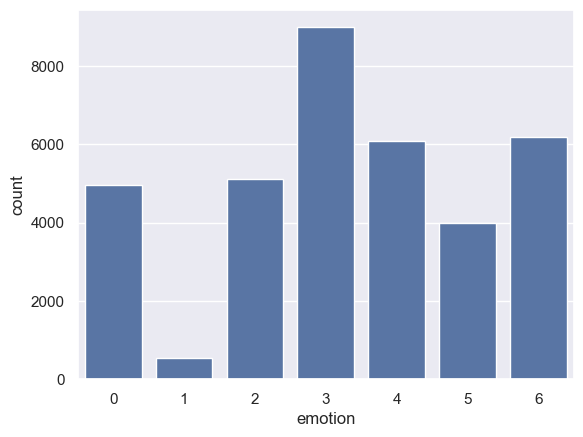

In [233]:
sns.countplot(x='emotion', data=df)
plt.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [234]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

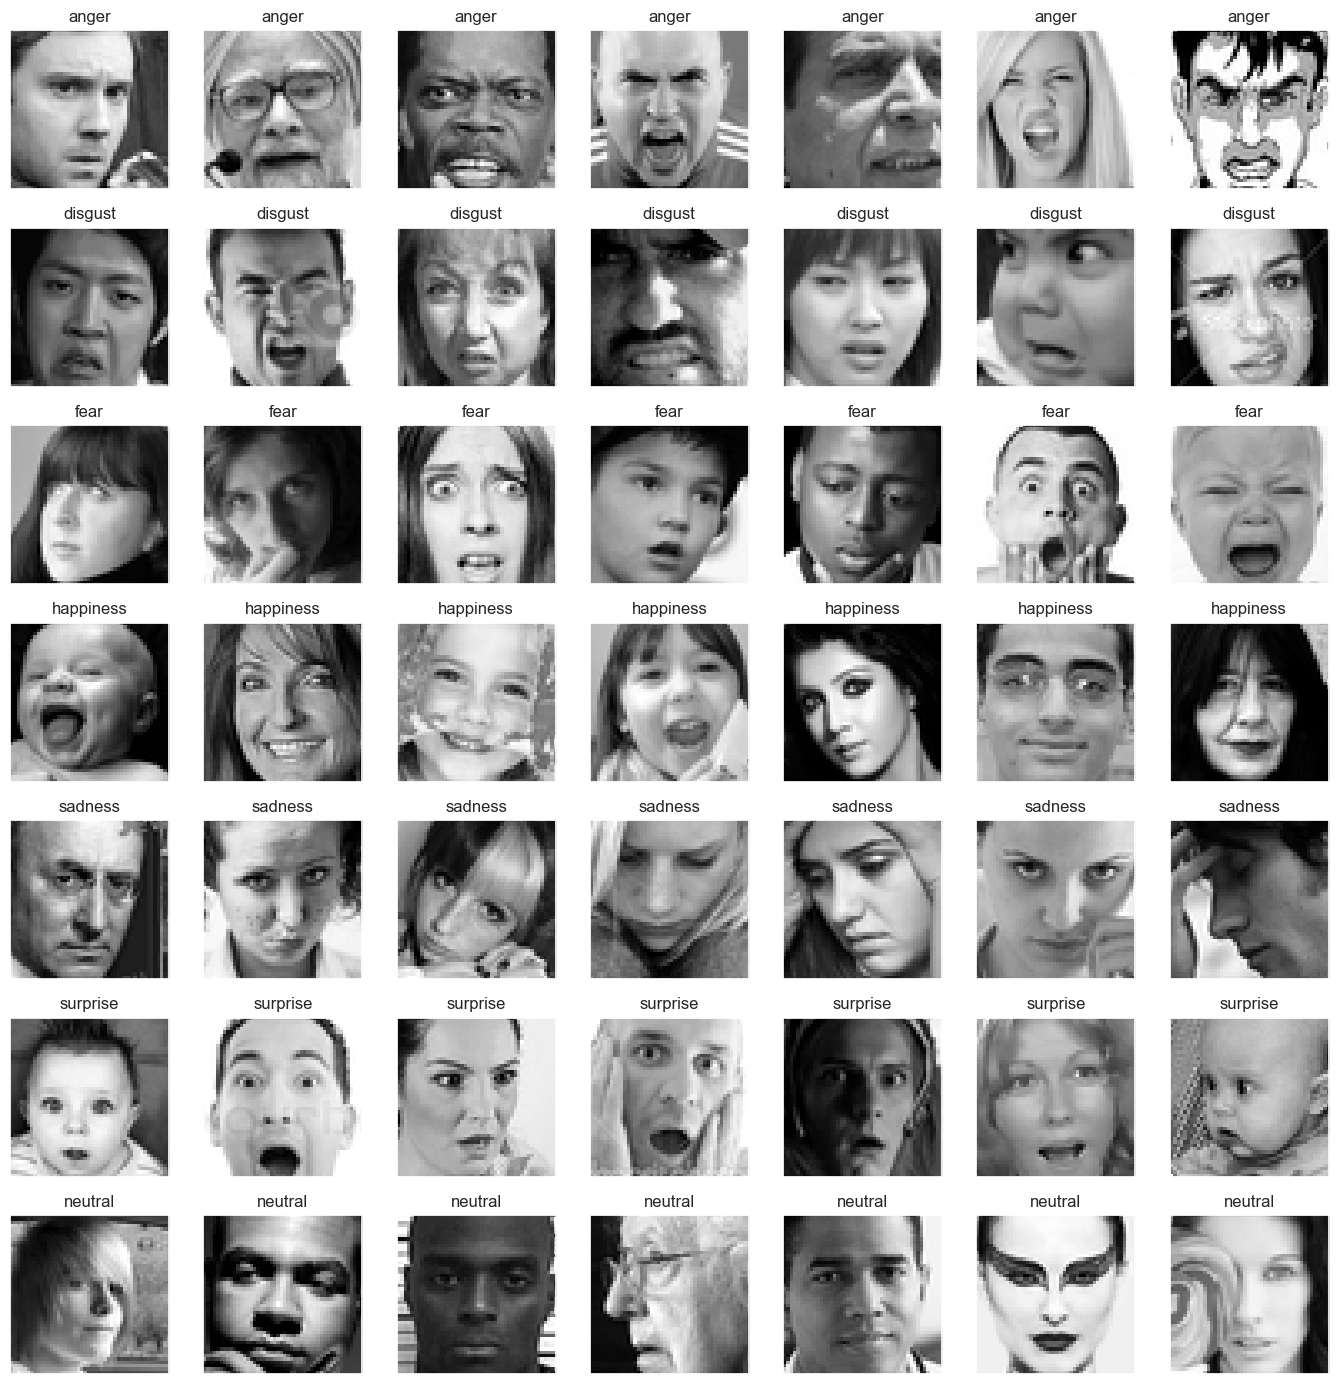

In [235]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [236]:
INTERESTED_LABELS = [0, 2, 3, 4, 5, 6]

In [237]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(35340, 3)

`Now I will make the data compatible for neural networks.`

In [238]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [239]:
img_array.shape

(35340, 48, 48, 1)

In [240]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape

(35340, 6)

In [241]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


`Splitting the data into training and validation set.`

In [242]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((31806, 48, 48, 1), (3534, 48, 48, 1), (31806, 6), (3534, 6))

In [243]:
del df
del img_array
del img_labels

In [244]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [245]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [210]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """

    net = Sequential(name='DCNN')

    # 1. Increased filters in Conv2D layers
    net.add(
        Conv2D(
            filters=128,  # Increased from 64
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=128,  # Increased from 64
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))  # 2. Reduced dropout rate

    # 2. Added another Conv2D layer with increased filters
    net.add(
        Conv2D(
            filters=256,  # Increased from 128
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=256,  # Increased from 128
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))  # 2. Reduced dropout rate

    # 3. Added another Conv2D layer with increased filters
    net.add(
        Conv2D(
            filters=512,  # Increased from 256
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=512,  # Increased from 256
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))  # 2. Reduced dropout rate

    net.add(Flatten(name='flatten'))
        
    # 4. Increased the number of neurons in the dense layer
    net.add(
        Dense(
            256,  # Increased from 128
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.4, name='dropout_4'))

    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    # Compile the model
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [252]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [246]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [213]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1]) 
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch = math.ceil(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks,
    #use_multiprocessing=False
)

/opt/anaconda3/envs/truthinators/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,566,854 (36.49 MB)

 Trainable params: 9,562,758 (36.48 MB)

 Non-trainable params: 4,096 (16.00 KB)

Epoch 1/100


/opt/anaconda3/envs/truthinators/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


994/994 ━━━━━━━━━━━━━━━━━━━━ 1422s 1s/step - accuracy: 0.2256 - loss: 2.2106 - val_accuracy: 0.3752 - val_loss: 1.5482 - learning_rate: 0.0010
Epoch 2/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1276s 1s/step - accuracy: 0.3596 - loss: 1.5869 - val_accuracy: 0.4836 - val_loss: 1.3284 - learning_rate: 0.0010
Epoch 3/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1302s 1s/step - accuracy: 0.4622 - loss: 1.3539 - val_accuracy: 0.5461 - val_loss: 1.1387 - learning_rate: 0.0010
Epoch 4/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1285s 1s/step - accuracy: 0.5237 - loss: 1.2308 - val_accuracy: 0.5402 - val_loss: 1.1885 - learning_rate: 0.0010
Epoch 5/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1307s 1s/step - accuracy: 0.5387 - loss: 1.1847 - val_accuracy: 0.6038 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 6/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1284s 1s/step - accuracy: 0.5588 - loss: 1.1381 - val_accuracy: 0.5979 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 7/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1287s 1s/step - accuracy: 0.5753 - loss: 

In [74]:
if not hasattr(model, 'output'):
    raise ValueError("Base model has no output layer. Check the architecture.")

ValueError: Base model has no output layer. Check the architecture.

In [214]:
model.save("model_param_modified.keras")

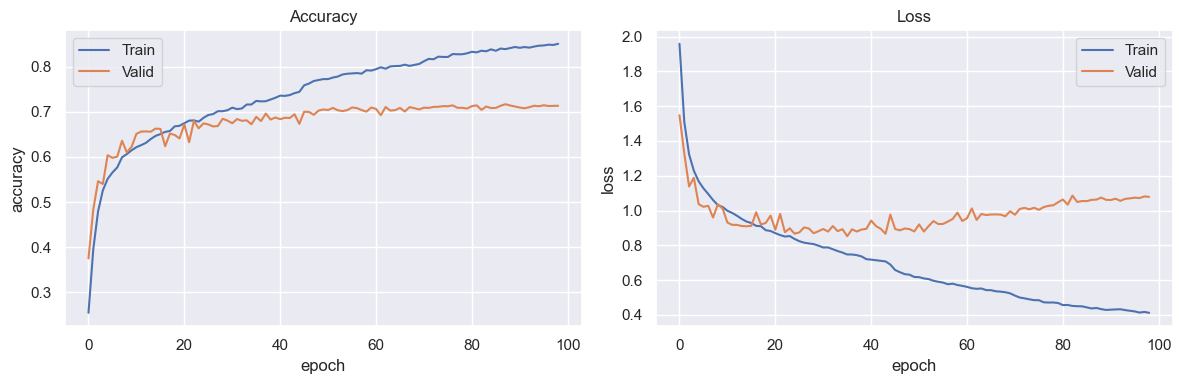

In [215]:
sns.set()
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Convert history data into DataFrame format for Seaborn
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch  # Add epoch numbers

# Plot accuracy
sns.lineplot(data=history_df, x="epoch", y="accuracy", label="Train", ax=axes[0])
sns.lineplot(data=history_df, x="epoch", y="val_accuracy", label="Valid", ax=axes[0])
axes[0].set_title("Accuracy")

# Plot loss
sns.lineplot(data=history_df, x="epoch", y="loss", label="Train", ax=axes[1])
sns.lineplot(data=history_df, x="epoch", y="val_loss", label="Valid", ax=axes[1])
axes[1].set_title("Loss")

# Improve layout and save the figure
plt.tight_layout()
plt.savefig("epoch_history_dcnn_param_modified.png")
plt.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

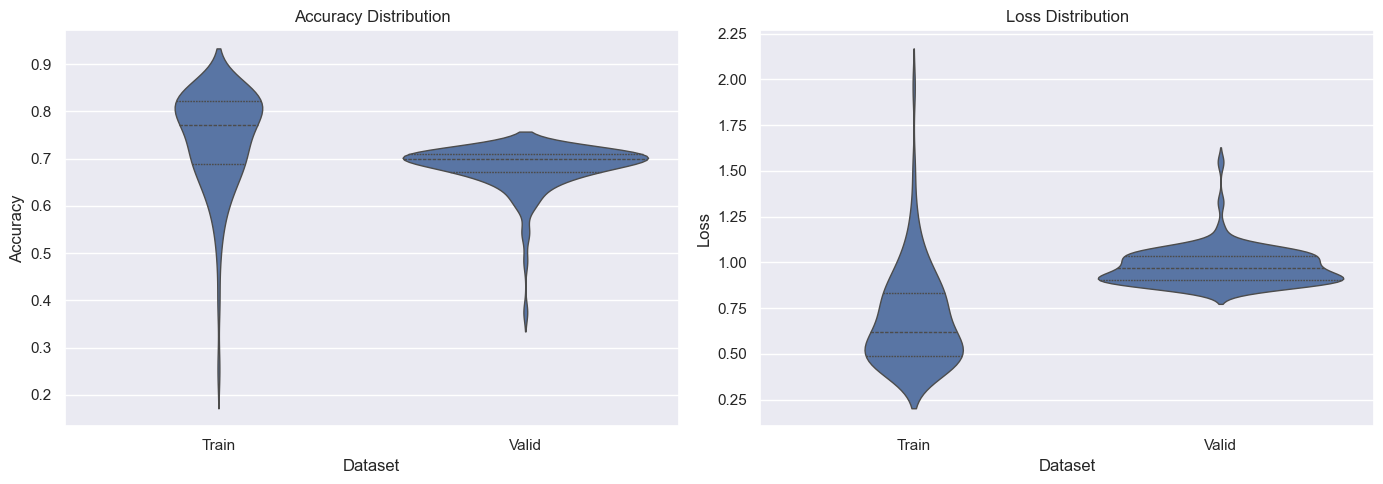

In [216]:
# Convert history data into DataFrame format
df_accu = pd.DataFrame({'Train': history.history['accuracy'], 'Valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'Train': history.history['loss'], 'Valid': history.history['val_loss']})

# Reshape data for Seaborn violin plot
df_accu_melted = df_accu.melt(var_name="Dataset", value_name="Accuracy")
df_loss_melted = df_loss.melt(var_name="Dataset", value_name="Loss")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Slightly increased size

# Violin plot for accuracy
sns.violinplot(x="Dataset", y="Accuracy", data=df_accu_melted, ax=axes[0], inner="quartile", linewidth = 1)
axes[0].set_title("Accuracy Distribution")

# Violin plot for loss
sns.violinplot(x="Dataset", y="Loss", data=df_loss_melted, ax=axes[1], inner="quartile", linewidth = 1)
axes[1].set_title("Loss Distribution")

# Adjust layout and save
plt.tight_layout()
plt.savefig("performance_dist_param_modified.png")
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       495
           1       0.62      0.58      0.60       512
           2       0.89      0.86      0.87       899
           3       0.65      0.56      0.60       608
           4       0.84      0.80      0.82       400
           5       0.62      0.78      0.69       620

    accuracy                           0.72      3534
   macro avg       0.71      0.70      0.70      3534
weighted avg       0.72      0.72      0.72      3534



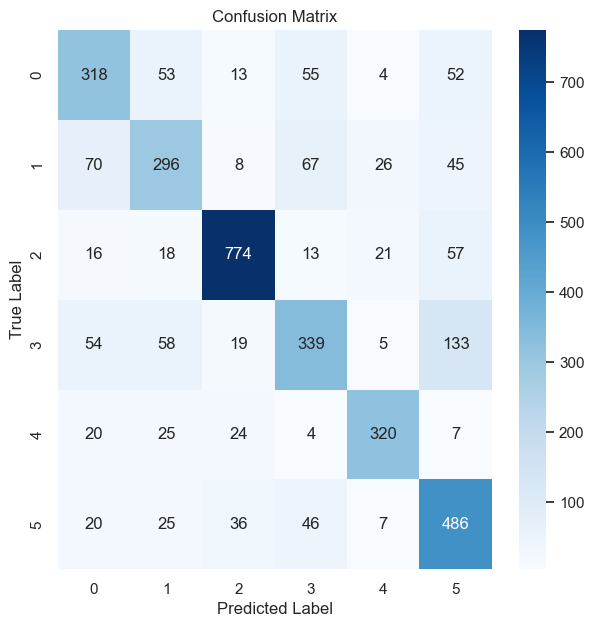

In [218]:
# Get predictions
yhat_valid = np.argmax(model.predict(X_valid), axis=1)  # Replace deprecated predict_classes()
y_true = np.argmax(y_valid, axis=1)

# Print classification report (Precision, Recall, F1-score)
report = classification_report(y_true, yhat_valid)
print(report)

with open("classification_report_param_modified.txt", "w") as file:
    file.write(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, yhat_valid)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_dcnn_param_modified.png")
plt.show()

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [28]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

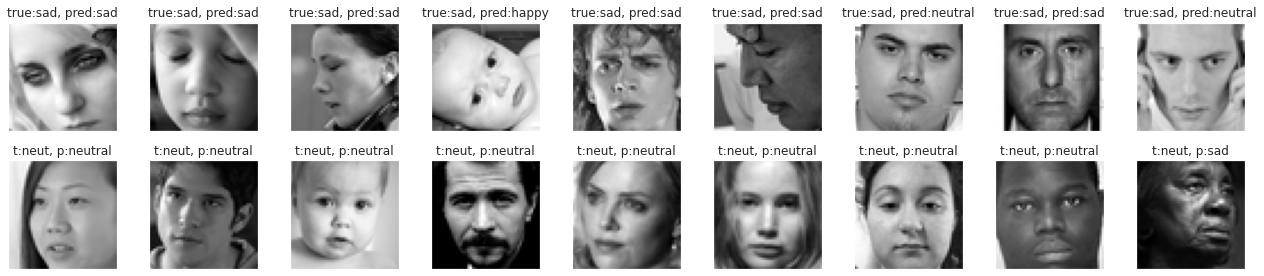

In [29]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = plt.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = plt.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        plt.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.

## Optimizing Section

In [49]:
for i, layer in enumerate(model_opt.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: conv2d_1
Layer 1: batchnorm_1
Layer 2: conv2d_2
Layer 3: batchnorm_2
Layer 4: maxpool2d_1
Layer 5: dropout_1
Layer 6: conv2d_3
Layer 7: batchnorm_3
Layer 8: conv2d_4
Layer 9: batchnorm_4
Layer 10: maxpool2d_2
Layer 11: dropout_2
Layer 12: conv2d_5
Layer 13: batchnorm_5
Layer 14: conv2d_6
Layer 15: batchnorm_6
Layer 16: maxpool2d_3
Layer 17: dropout_3
Layer 18: flatten
Layer 19: dense_1
Layer 20: batchnorm_7
Layer 21: dropout_4
Layer 22: out_layer


In [171]:
def modify_model_with_new_dense_layer(base_model, optim, num_classes):
    """
    Modify the pre-trained model by adding a new dense layer, batch normalization, and dropout
    before the output layer.
    """
    # Freeze the layers of the pre-trained model
    unfreeze_layers = [12, 13, 14, 15, 16, 17]
    for i, layer in enumerate(base_model.layers):
        if i not in unfreeze_layers:
            layer.trainable = False
        else:
            layer.trainable = True

    # Get the output of the last layer from the pre-trained base model
    x = base_model.get_layer('dropout_4').output

    # Add a Dense layer (128 units, ELU activation, He normal initialization)
    x = Dense(128, activation='elu', kernel_initializer='he_normal', name='dense_2')(x)
    
    # Add Batch Normalization and Dropout
    x = BatchNormalization(name='batchnorm_8')(x)
    x = Dropout(0.6, name='dropout_5')(x)

    # Add the final Output layer
    output = Dense(num_classes, activation='softmax', name='out_layer2')(x)

    # Create the new model
    input_layer = base_model.layers[0].input
    modified_model = Model(inputs = input_layer, outputs=output)

    # Compile the modified model (only the new layers will be trained)
    modified_model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
        
    return modified_model

In [172]:
base_model = load_model('/Users/huyguy/Documents/Documents - Huy’s MacBook Pro/UW/Clubs/Synaptech/truthinators/CNN Model/facial/Baseline Performace/model_baseline.keras')  # Load your pre-trained model

In [173]:
modified_model = modify_model_with_new_dense_layer(base_model, optim=optims[1], num_classes = num_classes)
modified_model.summary()

Model: "functional_734"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 128)            │           51

 Total params: 2,412,486 (9.20 MB)

 Trainable params: 903,814 (3.45 MB)

 Non-trainable params: 1,508,672 (5.76 MB)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [174]:
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]
# history_opt = modified_model.fit(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     validation_data=(X_valid, y_valid),
#     steps_per_epoch = math.ceil(len(X_train) / batch_size),
#     epochs=epochs,
#     callbacks=callbacks,
# )

Epoch 1/100


/opt/anaconda3/envs/truthinators/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


994/994 ━━━━━━━━━━━━━━━━━━━━ 203s 203ms/step - accuracy: 0.5702 - loss: 1.3054 - val_accuracy: 0.6904 - val_loss: 0.8877 - learning_rate: 0.0010
Epoch 2/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 185s 186ms/step - accuracy: 0.6651 - loss: 0.9110 - val_accuracy: 0.6916 - val_loss: 0.8533 - learning_rate: 0.0010
Epoch 3/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 186s 187ms/step - accuracy: 0.6823 - loss: 0.8699 - val_accuracy: 0.6910 - val_loss: 0.8535 - learning_rate: 0.0010
Epoch 4/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 186s 187ms/step - accuracy: 0.6719 - loss: 0.8838 - val_accuracy: 0.6986 - val_loss: 0.8551 - learning_rate: 0.0010
Epoch 5/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 184s 185ms/step - accuracy: 0.6776 - loss: 0.8803 - val_accuracy: 0.6885 - val_loss: 0.8783 - learning_rate: 0.0010
Epoch 6/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 185s 186ms/step - accuracy: 0.6786 - loss: 0.8740 - val_accuracy: 0.6913 - val_loss: 0.8709 - learning_rate: 0.0010
Epoch 7/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 189s 190ms/step - accuracy: 0

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            inplt_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [175]:
model.save("model_baseline_dense2_128_unfreeze_last_3rd_block.keras")

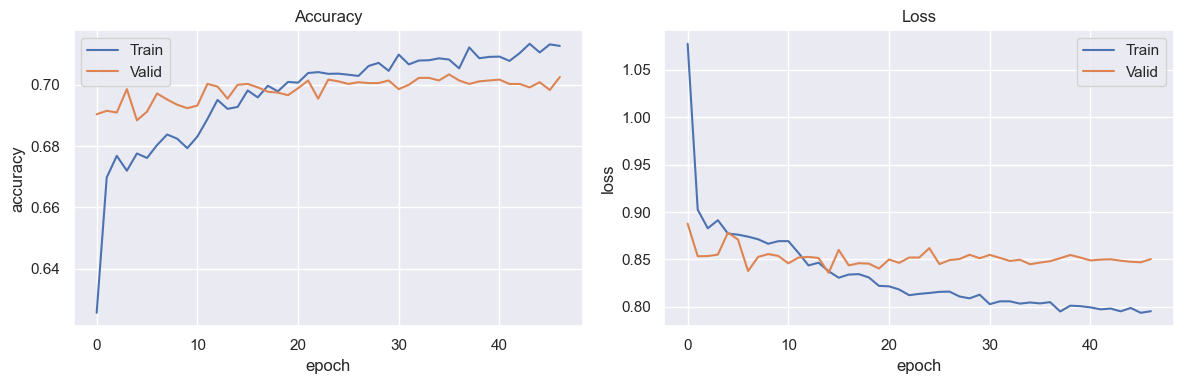

In [179]:
sns.set()
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Convert history data into DataFrame format for Seaborn
history_df = pd.DataFrame(history_opt.history)
history_df["epoch"] = history_opt.epoch  # Add epoch numbers

# Plot accuracy
sns.lineplot(data=history_df, x="epoch", y="accuracy", label="Train", ax=axes[0])
sns.lineplot(data=history_df, x="epoch", y="val_accuracy", label="Valid", ax=axes[0])
axes[0].set_title("Accuracy")

# Plot loss
sns.lineplot(data=history_df, x="epoch", y="loss", label="Train", ax=axes[1])
sns.lineplot(data=history_df, x="epoch", y="val_loss", label="Valid", ax=axes[1])
axes[1].set_title("Loss")

# Improve layout and save the figure
plt.tight_layout()
plt.savefig("epoch_history_dcnn_dense2_128_unfreeze_last_3rd_block.png")
plt.show()

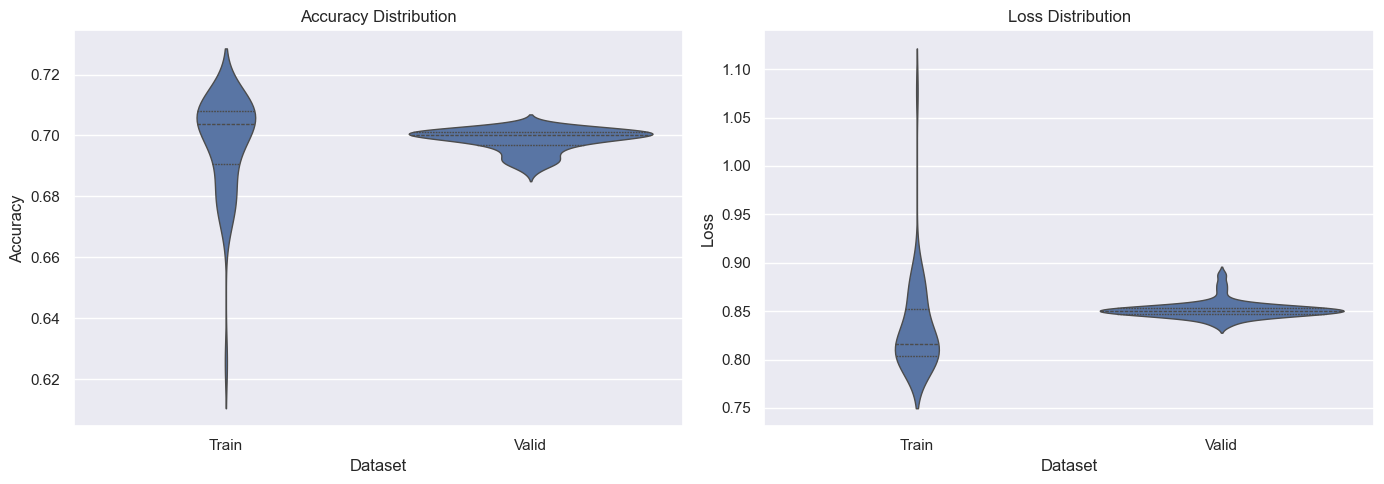

In [180]:
# Convert history data into DataFrame format
df_accu = pd.DataFrame({'Train': history_opt.history['accuracy'], 'Valid': history_opt.history['val_accuracy']})
df_loss = pd.DataFrame({'Train': history_opt.history['loss'], 'Valid': history_opt.history['val_loss']})

# Reshape data for Seaborn violin plot
df_accu_melted = df_accu.melt(var_name="Dataset", value_name="Accuracy")
df_loss_melted = df_loss.melt(var_name="Dataset", value_name="Loss")

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Slightly increased size

# Violin plot for accuracy
sns.violinplot(x="Dataset", y="Accuracy", data=df_accu_melted, ax=axes[0], inner="quartile", linewidth = 1)
axes[0].set_title("Accuracy Distribution")

# Violin plot for loss
sns.violinplot(x="Dataset", y="Loss", data=df_loss_melted, ax=axes[1], inner="quartile", linewidth = 1)
axes[1].set_title("Loss Distribution")

# Adjust layout and save
plt.tight_layout()
plt.savefig("performance_dist_dense2_128_unfreeze_last_3rd_block.png")
plt.show()

111/111 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step
              precision    recall  f1-score   support

           0       0.62      0.66      0.64       495
           1       0.59      0.41      0.48       512
           2       0.90      0.88      0.89       899
           3       0.60      0.63      0.61       608
           4       0.81      0.78      0.79       400
           5       0.62      0.75      0.68       620

    accuracy                           0.70      3534
   macro avg       0.69      0.69      0.68      3534
weighted avg       0.70      0.70      0.70      3534



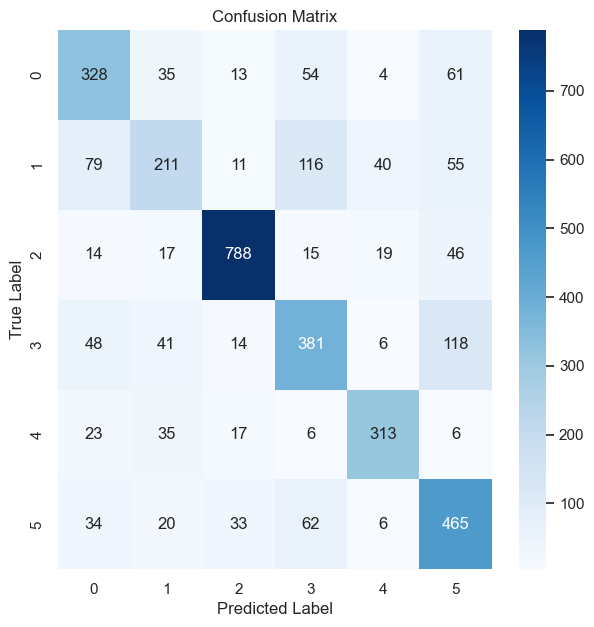

In [181]:
# Get predictions
yhat_valid = np.argmax(modified_model.predict(X_valid), axis=1)  # Replace deprecated predict_classes()
y_true = np.argmax(y_valid, axis=1)

# Print classification report (Precision, Recall, F1-score)
report = classification_report(y_true, yhat_valid)
print(report)

with open("classification_report_dense2_128_unfreeze_last_3rd_block.txt", "w") as file:
    file.write(report)

# Compute confusion matrix
cm = confusion_matrix(y_true, yhat_valid)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_dcnn_dense2_128_unfreeze_last_3rd_block.png")
plt.show()

In [248]:
model_p = load_model('/Users/huyguy/Documents/Documents - Huy’s MacBook Pro/UW/Clubs/Synaptech/truthinators/CNN Model/facial/Param Modified/model_param_modified.keras')  # Load your pre-trained model

In [249]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.layers import Dropout

def adjust_dropout_rate(model, new_dropout_rate):
    # Clone the model architecture
    config = model.get_config()

    # Loop through layers and adjust Dropout rates
    for layer in config['layers']:
        if "dropout_" in layer['class_name'].lower():
            layer['config']['rate'] = new_dropout_rate

    # Build the new model from the modified config
    new_model = model.__class__.from_config(config)

    # Transfer weights
    new_model.set_weights(model.get_weights())

    return new_model

# Example usage:
new_model = adjust_dropout_rate(model_p, 0.4)

In [222]:
new_model.summary()

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 128)    │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_1                     │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_2                     │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_1 (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_3                     │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_4                     │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_2 (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_5                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_6                     │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2d_3 (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_7                     │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 9,566,854 (36.49 MB)

 Trainable params: 9,562,758 (36.48 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [ ]:
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]
new_model.compile(
    loss='categorical_crossentropy',
    optimizer=optims[0],
    metrics=['accuracy']
)

history_opt = new_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=math.ceil(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/100


/opt/anaconda3/envs/truthinators/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


994/994 ━━━━━━━━━━━━━━━━━━━━ 1922s 2s/step - accuracy: 0.8213 - loss: 0.4826 - val_accuracy: 0.7026 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 2/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1467s 1s/step - accuracy: 0.8067 - loss: 0.5331 - val_accuracy: 0.6955 - val_loss: 1.0423 - learning_rate: 0.0010
Epoch 3/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1358s 1s/step - accuracy: 0.7979 - loss: 0.5447 - val_accuracy: 0.7006 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 4/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1354s 1s/step - accuracy: 0.8071 - loss: 0.5261 - val_accuracy: 0.6921 - val_loss: 1.0221 - learning_rate: 0.0010
Epoch 5/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1313s 1s/step - accuracy: 0.8022 - loss: 0.5420 - val_accuracy: 0.6927 - val_loss: 1.0976 - learning_rate: 0.0010
Epoch 6/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1305s 1s/step - accuracy: 0.8061 - loss: 0.5376 - val_accuracy: 0.7037 - val_loss: 0.9621 - learning_rate: 0.0010
Epoch 7/100
994/994 ━━━━━━━━━━━━━━━━━━━━ 1339s 1s/step - accuracy: 0.8054 - loss: 